# Question 2: Traffic

### Load Packages and Processed Data

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import chain  
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import scipy
from scipy.optimize import minimize
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt  
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

X_train_loaded = torch.load('question2_traffic\X_train2.pt')
y_train_loaded = torch.load('question2_traffic\y_train2.pt')
lengths_train_loaded = torch.load('question2_traffic\lengths_train2.pt')

X_test_loaded = torch.load('question2_traffic\X_test2.pt')
y_test_loaded = torch.load('question2_traffic\y_test2.pt')
lengths_test_loaded = torch.load('question2_traffic\lengths_test2.pt')

train_loader = DataLoader(TensorDataset(X_train_loaded, y_train_loaded, lengths_train_loaded), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_loaded, y_test_loaded, lengths_test_loaded), batch_size=128, shuffle=False)

### Initialize Models and Load Pre-trained Model Weights

In [2]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, lengths):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), hidden_size).to(x.device)

        if type(lengths)==int:
            sorted_lengths = torch.tensor([lengths]).to(x.device)
            sorted_x = x
        else:
            sorted_lengths, sort_idx = lengths.sort(descending=True)
            sorted_x = x[sort_idx]

        packed_x = nn.utils.rnn.pack_padded_sequence(sorted_x, sorted_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hn = self.gru(packed_x, h0)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        last_indices = (output_lengths - 1).long()

        last_output = output[torch.arange(output.size(0)), last_indices, :]

        if type(lengths)!=int:
          _, original_idx = sort_idx.sort()
          last_output = last_output[original_idx]
        last_output = self.layer_norm(last_output)
        last_output = self.dropout(last_output)
        logits = self.fc(last_output)
        return logits
input_size = 2 
hidden_size = 128
num_layers = 2
GRUmodel = GRUClassifier(input_size, hidden_size, num_layers)


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, lengths):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), hidden_size).to(x.device)
        if type(lengths)==int:
          sorted_lengths = torch.tensor([lengths]).to(x.device)
          sorted_x = x
        else:
          sorted_lengths, sort_idx = lengths.sort(descending=True)
          sorted_x = x[sort_idx]

        packed_x = nn.utils.rnn.pack_padded_sequence(sorted_x, sorted_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_x, (h0, c0))
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        last_indices = (output_lengths - 1).long()

        last_output = output[torch.arange(output.size(0)), last_indices, :]

        if type(lengths)!=int:
          _, original_idx = sort_idx.sort()
          last_output = last_output[original_idx]
        
        last_output = self.layer_norm(last_output)
        last_output = self.dropout(last_output)
        logits = self.fc(last_output)
        return logits
input_size = 2 
hidden_size = 128
num_layers = 2
LSTMmodel = LSTMClassifier(input_size, hidden_size, num_layers)


class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dim_feedforward, num_classes, max_seq_len):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.position_encoding = nn.Parameter(torch.zeros(1, max_seq_len, model_dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=model_dim,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=num_layers
        )
        self.layer_norm = nn.LayerNorm(model_dim)
        self.fc = nn.Linear(model_dim, num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x, lengths):
        x = self.embedding(x) + self.position_encoding[:, :x.size(1), :]

        attention_mask = self.create_attention_mask(lengths, x.size(1)).to(x.device)

        x = self.transformer(x, src_key_padding_mask=attention_mask)
        x = self.layer_norm(x)
        x = self.masked_mean(x, lengths, dim=0)
        x = self.fc(x)
        return x

    def create_attention_mask(self, lengths, max_len):
        if isinstance(lengths, int):
            lengths = torch.tensor([lengths]).to(device)
        attention_mask = torch.zeros(len(lengths), max_len, dtype=torch.bool)
        for i, length in enumerate(lengths):
            attention_mask[i, :length] = 1
        return ~attention_mask

    def masked_mean(self, x, lengths, dim=0):  
        batch_size = x.size(0)  
        result = []  
        for i in range(batch_size): 
            if isinstance(lengths, int):
                length = lengths
            else:
                length = lengths[i]  
            sliced = x[i, :length, :]  
            mean_value = sliced.mean(dim=dim)  
            result.append(mean_value)  
        result_tensor = torch.stack(result)  
        return result_tensor 
input_dim = 2
model_dim = 128  # Dimension of the embeddings and transformer model
dim_feedforward = 256
num_heads = 8  # Number of attention heads
num_layers = 2  # Number of transformer encoder layers
num_classes = 1  # Number of classes for classification
max_seq_len = X_train_loaded.size(1)  # Maximum sequence length
TFmodel = TransformerClassifier(input_dim, model_dim, num_heads, num_layers, dim_feedforward, num_classes, max_seq_len)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRUmodel.load_state_dict(torch.load('question2_traffic\GRUmodel_q2.pth', map_location=device)) 
LSTMmodel.load_state_dict(torch.load('question2_traffic\LSTMmodel_q2.pth', map_location=device))
TFmodel.load_state_dict(torch.load('question2_traffic\TFmodel_q2.pth', map_location=device))

<All keys matched successfully>

In [3]:
def reshape_and_convert(X, y, start_id=0):
    reshaped_X = X.view(-1, X.size(-1)).numpy()
    ids = np.repeat(np.arange(start_id, start_id + X.size(0)), X.size(1))
    df = pd.DataFrame(reshaped_X, columns=['action', 'time'])
    df['ID'] = ids
    df = df[df['action'] != -1]
    return df, y.numpy()

train_df, train_label = reshape_and_convert(X_train_loaded, y_train_loaded)
test_df, test_label = reshape_and_convert(X_test_loaded, y_test_loaded, start_id=X_train_loaded.size(0))

df = pd.concat([train_df, test_df]) 
grouped = df.groupby('ID')  
last_times = grouped['time'].max() 
action_count = grouped['action'].count()

def generate_ngrams(series, n):  
    return [' '.join(map(str, series[i:i+n])) for i in range(len(series)-n+1)]  
  
ngrams_features = defaultdict(lambda: defaultdict(int))  
  
for id_, group in grouped:  
    actions = group['action'].tolist()  
    for n in range(1, 4):  # 1-gram, 2-gram, 3-gram
        for ngram in generate_ngrams(actions, n):  
            ngrams_features[id_][ngram] += 1  
            
feature_names = set(chain.from_iterable(ngrams_features.values()))  
ngram_df = pd.DataFrame(0, index=df['ID'].unique(), columns=list(feature_names))  
  
for id_, counts in ngrams_features.items():  
    for ngram, count in counts.items():  
        ngram_df.at[id_, ngram] = count  

ngram_df['last_time'] = last_times  
ngram_df['action_count'] = action_count 
train_features = ngram_df.iloc[:25311]
test_features = ngram_df.iloc[25311:]

Logitmodel = LogisticRegression()  
Logitmodel.fit(train_features, train_label)   

LogisticRegression()

### Evaluate Models 

In [4]:
models = [GRUmodel, LSTMmodel, TFmodel]
for model in models:
    model.eval()
    correct = 0
    total = 0
    all_probs = []
    with torch.no_grad():
        for inputs, labels, lengths in test_loader:
            inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)

            outputs = model(inputs, lengths).squeeze()
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities >= 0.5).long()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_probs.extend(probabilities.numpy())
    auc = roc_auc_score(y_test_loaded, all_probs)
    print(f'AUC & Accuracy of the {model} on the test data: {auc:.4f} & {correct / total:.4f}')

score = Logitmodel.score(test_features, test_label) 
test_probs = Logitmodel.predict_proba(test_features)[:, 1]
auc_score = roc_auc_score(test_label, test_probs)  
print(f"AUC & Accuracy of the Logistic Regression model on the test data: {auc_score:.4f} & {score:.4f}")

AUC & Accuracy of the GRUClassifier(
  (gru): GRU(2, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
) on the test data: 0.8468 & 0.8006
AUC & Accuracy of the LSTMClassifier(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
) on the test data: 0.8422 & 0.7969
AUC & Accuracy of the TransformerClassifier(
  (embedding): Linear(in_features=2, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_featu

In [5]:
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _, lengths in data_loader:
            inputs, lengths = inputs.to(device), lengths.to(device)
            outputs = model(inputs, lengths)
            probabilities = torch.sigmoid(outputs.squeeze())
            predicted = (probabilities >= 0.5).long()
            predictions.append(predicted.cpu())
    return torch.cat(predictions)

gru_predictions = get_predictions(GRUmodel, test_loader, device)
lstm_predictions = get_predictions(LSTMmodel, test_loader, device)
tf_predictions = get_predictions(TFmodel, test_loader, device)
logit_predictions = torch.tensor(Logitmodel.predict(test_features))

all_correct_indices = (gru_predictions == y_test_loaded) & (lstm_predictions == y_test_loaded) & (tf_predictions == y_test_loaded) & (logit_predictions == y_test_loaded)
all_correct_samples = torch.nonzero(all_correct_indices).squeeze().tolist()

all_incorrect_indices = (gru_predictions != y_test_loaded) & (lstm_predictions != y_test_loaded) & (tf_predictions != y_test_loaded) & (logit_predictions != y_test_loaded)
all_incorrect_samples = torch.nonzero(all_incorrect_indices).squeeze().tolist()

print(f"Number of samples where all models are correct: {len(all_correct_samples)}")
print(f"Number of samples where all models are incorrect: {len(all_incorrect_samples)}")
print(f"Number of all samples: {len(gru_predictions)}")

Number of samples where all models are correct: 4252
Number of samples where all models are incorrect: 576
Number of all samples: 6328


### Construct Probability Curves

In [ ]:
action_count = []
ngrams_features = defaultdict(lambda: defaultdict(int)) 

for id_ in range(25311, 31639):  
    id_data = df.loc[df['ID'] == id_]  
    n_rows = len(id_data) 
    for prefix_len in range(1, n_rows + 1):  
        prefix_data = id_data.iloc[:prefix_len]     
        
        action_count.append((id_, prefix_len, len(prefix_data))) 
        
        for n in range(1, 4):  # 1-gram, 2-gram, 3-gram
            for ngram in generate_ngrams(prefix_data['action'], n):  
                ngrams_features[(id_, prefix_len)][ngram] += 1  

action_count_features = pd.DataFrame(  
    {  'action_count': [f[2] for f in action_count] },  
    index=pd.MultiIndex.from_tuples([f[:2] for f in action_count])
)  

ngram_df = pd.DataFrame(0, index=action_count_features.index, columns=list(feature_names))  
  
for (id_, prefix_len), counts in ngrams_features.items():  
    for ngram, count in counts.items():  
        ngram_df.at[(id_, prefix_len), ngram] = count  
ngram_df['last_time'] = test_df['time'].values
ngram_df['action_count'] = action_count_features['action_count'].values

long_prob_curve_logit = {}
long_labels_logit = {}

for id_ in range(25311, 31639):
    expanded_id_features = ngram_df.loc[id_,:]
    if len(expanded_id_features)>10:
        long_prob_curve_logit[id_ - 25311] = Logitmodel.predict_proba(expanded_id_features)[:, 1]
        long_labels_logit[id_ - 25311] = test_label[id_ - 25311]


long_prob_curve_TF1 = {}
long_prob_curve_TF2 = {}
long_prob_curve_TF3 = {}
long_prob_curve_TF4 = {}
long_labels_TF = {}

models = [GRUmodel, LSTMmodel, TFmodel]
long_prob_curve_dicts = [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4]

for i, (test_seq, test_label, test_len) in enumerate(zip(X_test_loaded, y_test_loaded, lengths_test_loaded)):
    if test_len > 10:
        for model, prob_curve_dict in zip(models, long_prob_curve_dicts[:3]):
            prob_curve = []
            for t in range(1, test_len + 1):
                current_seq = test_seq[:t].unsqueeze(0)
                current_seq = current_seq.to(device)
                with torch.no_grad():
                    logits = model(current_seq, t)
                    probs = torch.sigmoid(logits)
                prob_curve.append(probs.squeeze().cpu().numpy())  
                
            prob_curve_dict[i] = np.array(prob_curve)
        long_prob_curve_TF4[i] = long_prob_curve_logit[i]
        long_labels_TF[i] = test_label.numpy()

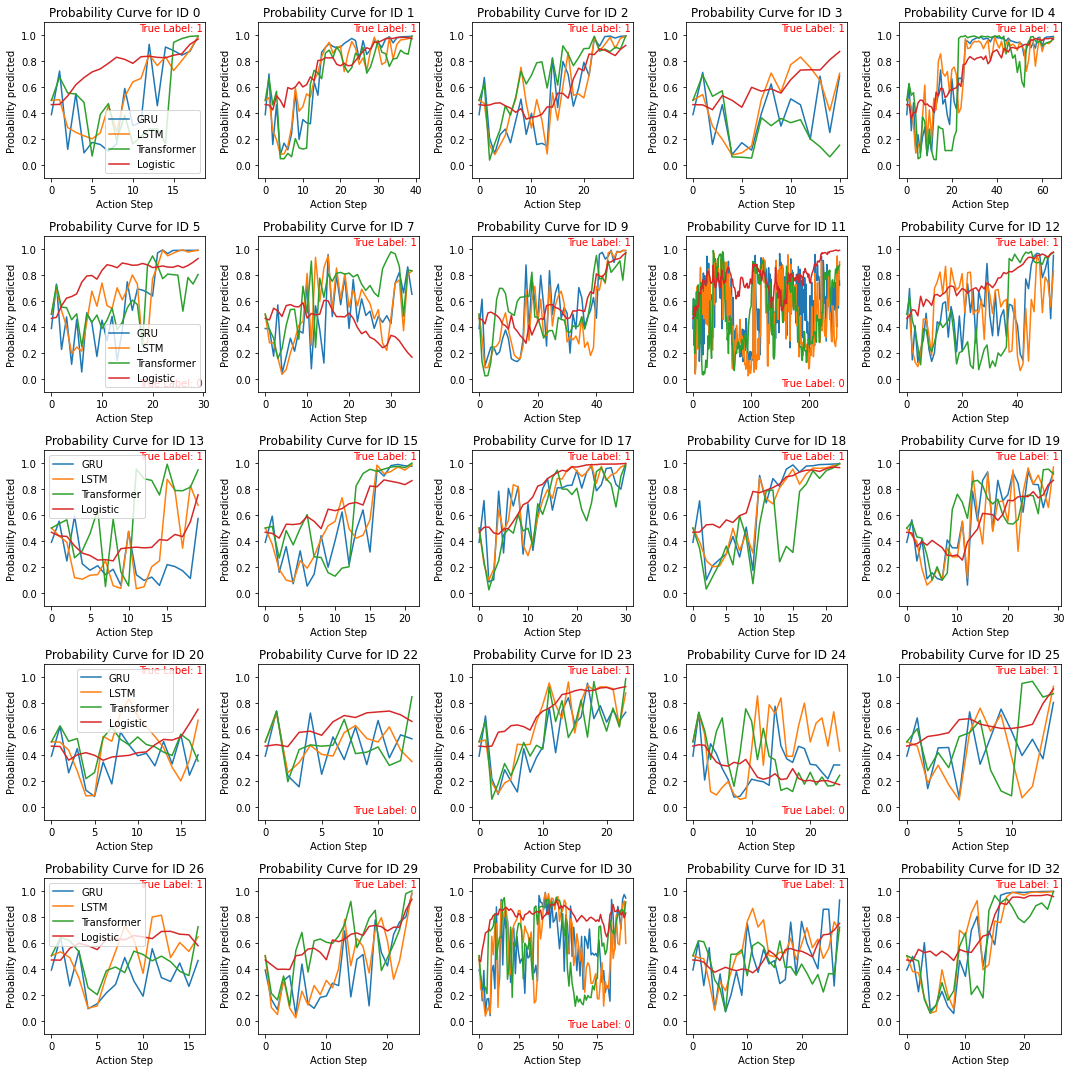

In [7]:
valid_ids = list(long_labels_TF.keys())[:25]
model_names = ['GRU', 'LSTM', 'Transformer', 'Logistic']

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i, id_ in enumerate(valid_ids):
    row, col = divmod(i, 5)
    ax = axs[row, col]
    
    for model_idx, prob_curve_dict in enumerate(long_prob_curve_dicts):
        prob_curve = prob_curve_dict[id_]
        ax.plot(prob_curve, label=model_names[model_idx])

    labels = long_labels_TF[id_]

    ax.set_ylim(-0.1, 1.1) 
    ax.set_xlabel('Action Step')
    ax.set_ylabel('Probability predicted')
    ax.set_title(f'Probability Curve for ID {id_}')
    
    time_point = len(prob_curve) - 1
    probability = prob_curve[-1]
    if labels == 1:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, 1.05),
                    xytext=(time_point * 0.6, 1.03),
                    fontsize=10,
                    color='red')
    if labels == 0:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, -0.05),
                    xytext=(time_point * 0.6, -0.05),
                    fontsize=10,
                    color='red')
    if col == 0:
        ax.legend()  
    
plt.tight_layout()
plt.show()

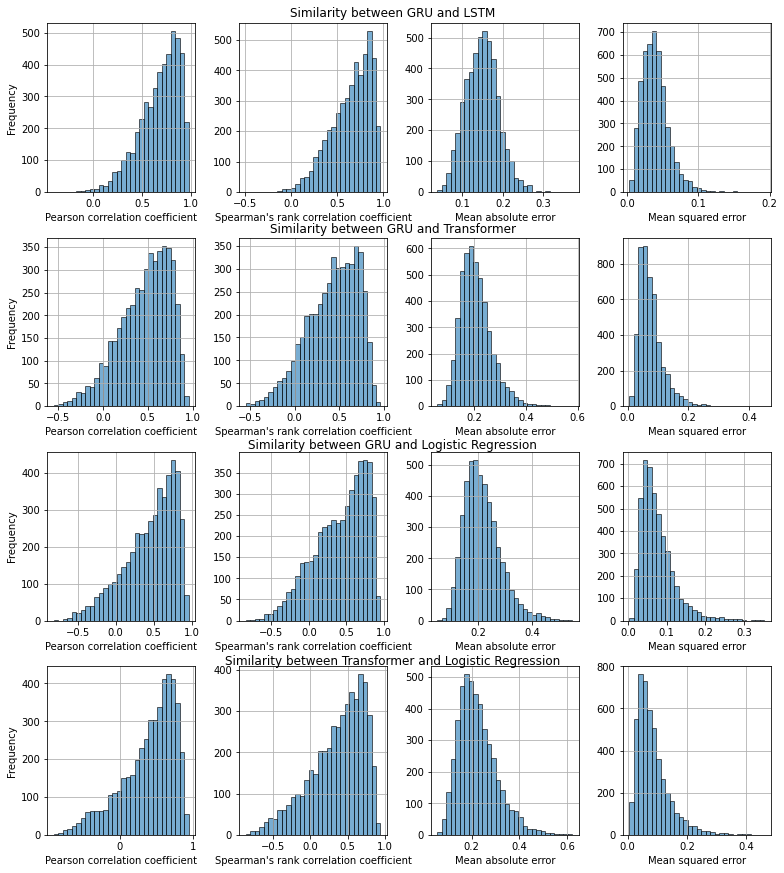

In [8]:
# Function to compute similarity metrics
def compute_similarity_metrics(id_, curves):
    metrics = {}
    keys = ["12", "13", "14", "34"]
    combinations = [(0, 1), (0, 2), (0, 3), (2, 3)]
    
    for key, (i, j) in zip(keys, combinations):
        curve1, curve2 = curves[i], curves[j]
        metrics[f'pearson{key}'] = scipy.stats.pearsonr(curve1, curve2)[0]
        metrics[f'spearman{key}'] = scipy.stats.spearmanr(curve1, curve2)[0]
        metrics[f'MAE{key}'] = np.mean(np.abs(curve1 - curve2))
        metrics[f'MSE{key}'] = np.mean((curve1 - curve2) ** 2)
    
    return metrics

# Process data and compute similarities
similarities = []
for id_ in long_prob_curve_TF1:
    if id_ in long_prob_curve_TF2:
        curves = [
            long_prob_curve_TF1[id_],
            long_prob_curve_TF2[id_],
            long_prob_curve_TF3[id_],
            long_prob_curve_TF4[id_]
        ]
        metrics = compute_similarity_metrics(id_, curves)
        metrics['ID'] = id_
        similarities.append(metrics)

# Create DataFrame from computed similarities
df_similarities = pd.DataFrame(similarities).set_index('ID')

# Plot similarities
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 12))
titles = [
    'Similarity between GRU and LSTM',
    'Similarity between GRU and Transformer',
    'Similarity between GRU and Logistic Regression',
    'Similarity between Transformer and Logistic Regression'
]
xlabels = [
    'Pearson correlation coefficient',
    "Spearman's rank correlation coefficient",
    'Mean absolute error',
    'Mean squared error'
]

for i, col in enumerate(df_similarities.columns):
    row, col_index = divmod(i, ncols)
    ax = axes[row, col_index]
    df_similarities[col].hist(bins=30, alpha=0.6, edgecolor='black', ax=ax)
    # ax.set_title(col)
    ax.set_xlabel(xlabels[col_index])
    if col_index == 0:
        ax.set_ylabel('Frequency')

for idx, title in enumerate(titles):
    fig.text(0.5, 0.995 - 0.25 * idx, title, ha='center', fontsize=12)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.show()

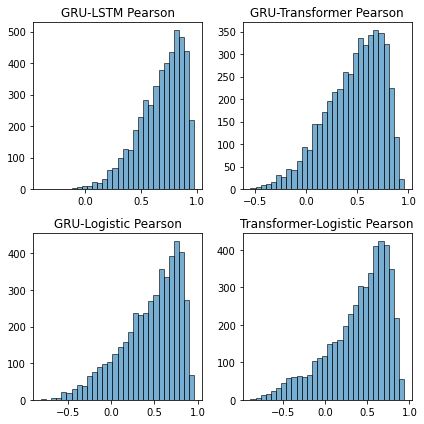

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))  # Adjust figsize as needed

titles = [
    'GRU-LSTM Pearson',
    'GRU-Transformer Pearson',
    'GRU-Logistic Pearson',
    'Transformer-Logistic Pearson'
]
columns = ['pearson12', 'pearson13', 'pearson14', 'pearson34']

# Plot histograms in a loop
for ax, col, title in zip(axs.flat, columns, titles):
    ax.hist(df_similarities[col], bins=30, alpha=0.6, edgecolor='black')
    ax.set_title(title)

plt.tight_layout()
plt.show()

### B-Spline Fitting

In [10]:
all_spline = {}
spline_curve = {}

degree = 3

def loss_function(control_points):
    spl = BSpline(knots, control_points, degree)    
    loss = np.sum((spl(x) - y1)**2) + np.sum((spl(x) - y2)**2) + np.sum((spl(x) - y3)**2) + np.sum((spl(x) - y4)**2)
    return loss

for id_ in list(long_labels_TF.keys()):
    x = np.arange(1, len(long_prob_curve_TF1[id_]) + 1)
    x_fine = np.linspace(1, len(x), 200)
    y1 = long_prob_curve_TF1[id_]
    y2 = long_prob_curve_TF2[id_]
    y3 = long_prob_curve_TF3[id_]
    y4 = long_prob_curve_TF4[id_]
    y = (y1 + y2 + y3 + y4) / 4

    knots = np.concatenate(([1], x[::3], [len(x), len(x), len(x)]))
    initial_control_points = np.random.rand(len(knots) - 3)

    result = minimize(loss_function, initial_control_points, method='BFGS')

    spline = BSpline(knots, result.x, degree)

    spline_curve[id_] = spline(x)
    all_spline[id_] = spline(x_fine)

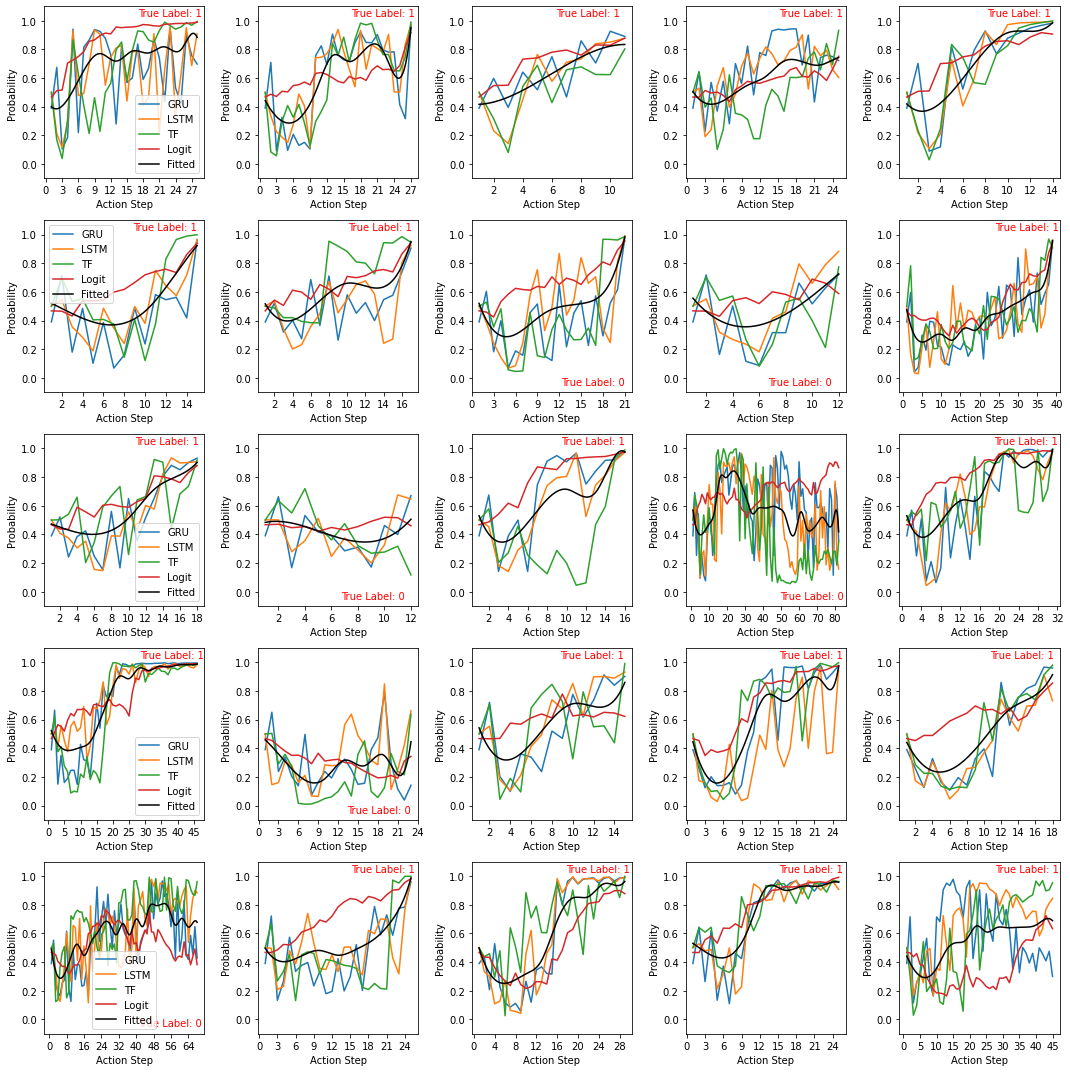

In [11]:
valid_ids = list(long_labels_TF.keys())[125:150]
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i, id_ in enumerate(valid_ids):
    row, col = divmod(i, 5)
    ax = axs[row, col]
    x = np.arange(1, len(long_prob_curve_TF1[id_]) + 1)
    ax.plot(x, long_prob_curve_TF1[id_], label='GRU')
    ax.plot(x, long_prob_curve_TF2[id_], label='LSTM')
    ax.plot(x, long_prob_curve_TF3[id_], label='TF')
    ax.plot(x, long_prob_curve_TF4[id_], label='Logit')

    x_fine = np.linspace(1, len(x), 200)    
    ax.plot(x_fine, all_spline[id_], label='Fitted', color='black')
    labels = long_labels_TF[id_]

    ax.set_ylim(-0.1, 1.1) 
    ax.set_xlabel('Action Step')
    ax.set_ylabel('Probability')
    # ax.set_title(f'Probability Curve for ID {id_}')

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    time_point = len(long_prob_curve_TF4[id_]) - 1
    if labels == 1:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, 1.05),
                    xytext=(time_point * 0.63, 1.03),
                    fontsize=10,
                    color='red')
    if labels == 0:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, -0.05),
                    xytext=(time_point * 0.61, -0.05),
                    fontsize=10,
                    color='red')
    if col == 0:
        ax.legend()  

plt.tight_layout()
plt.show()

### Task 1: Measure correct guessing probability

In [12]:
first_values_sum = 0  # Initialize a variable to store the sum of all first values
count = 0   # Initialize a variable to store the count of first values

# Iterate through all curves in the dictionary
for curve in spline_curve.values():
    if curve.size > 0:
        first_values_sum += curve[0]
        count += 1

# Calculate the average
if count > 0:
    average_first_value = first_values_sum / count
else:
    average_first_value = 0

print(f"The average of the first values across all curves is: {average_first_value:.4f}")

The average of the first values across all curves is: 0.5112


### Task 2: Identify key actions

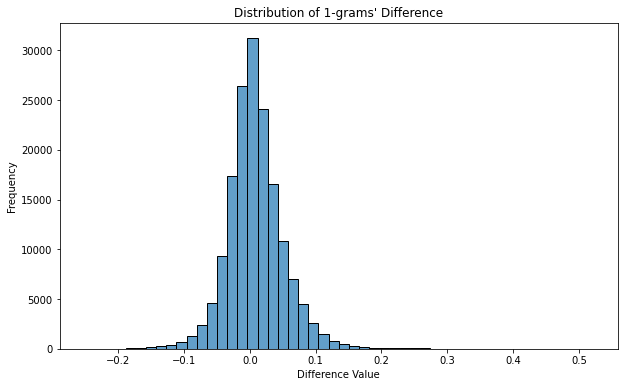

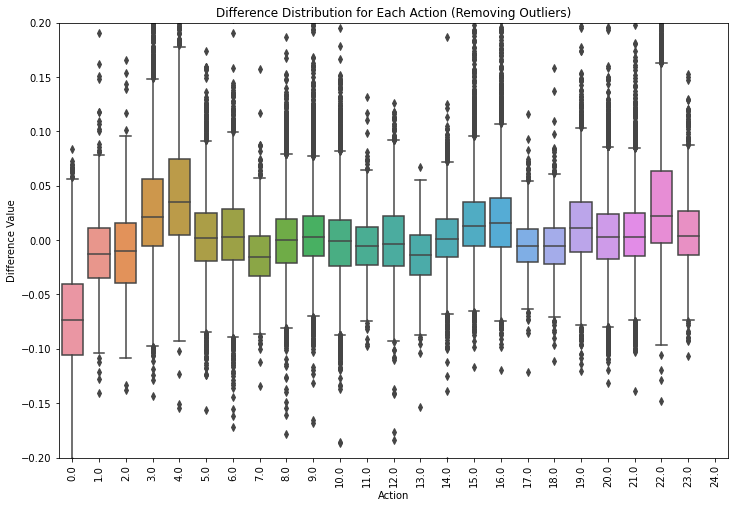

In [13]:
action_diffs = []
test_df['id'] = test_df['ID'] - 25311
test_slope1 = test_df[test_df['id'].isin(list(long_labels_TF.keys()))]

for id_ in list(long_labels_TF.keys()):
    x = np.arange(1, len(long_prob_curve_TF1[id_]) + 1)
    fitted_curve = spline_curve[id_]
    
    diffs = fitted_curve[1:] - fitted_curve[:-1]
    action_diffs.extend(diffs)
    diffs_with_nan = np.insert(diffs, x[-1]-1, np.nan)
    test_slope1.loc[test_slope1['id'] == id_, 'action_diffs'] = diffs_with_nan

plt.figure(figsize=(10, 6))
sns.histplot(action_diffs, bins=50, alpha=0.7)
plt.title("Distribution of 1-grams' Difference")
plt.xlabel('Difference Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='action', y='action_diffs', data=test_slope1)
plt.xticks(rotation=90)
plt.ylim(-0.2, 0.2) 
plt.title('Difference Distribution for Each Action (Removing Outliers)')
plt.xlabel('Action')
plt.ylabel('Difference Value')
plt.show()

In [14]:
grouped1 = test_slope1.groupby('action')['action_diffs'].median().reset_index()
grouped2 = test_slope1.groupby('action')['action_diffs'].mean().reset_index(drop=True)
grouped3 = test_slope1.groupby('action')['action_diffs'].count().reset_index(drop=True)
grouped = pd.concat([grouped1, grouped2, grouped3],axis=1)
grouped.columns = ['action', 'median', 'mean', 'count']

large_slope = grouped[(grouped['median'] > 0.008) & (grouped['count'] > 20)]
print("good 1-grams:")
print(large_slope)

negtive_slope = grouped[(grouped['median'] < -0.005) & (grouped['count'] > 20)]
print("bad 1-grams:")
print(negtive_slope)

good 1-grams:
    action    median      mean  count
3      3.0  0.021232  0.026108  13374
4      4.0  0.034847  0.040536   8945
15    15.0  0.013190  0.017483   6356
16    16.0  0.015465  0.018833   7960
19    19.0  0.011140  0.013165   8759
22    22.0  0.022206  0.035560  11960
bad 1-grams:
    action    median      mean  count
0      0.0 -0.073713 -0.071799   4734
1      1.0 -0.012462 -0.010390    985
2      2.0 -0.010178 -0.009841    578
7      7.0 -0.015337 -0.014518   1628
11    11.0 -0.005867 -0.004805   1618
13    13.0 -0.013649 -0.013413    502
17    17.0 -0.005397 -0.004031    906
18    18.0 -0.005706 -0.004468   1002


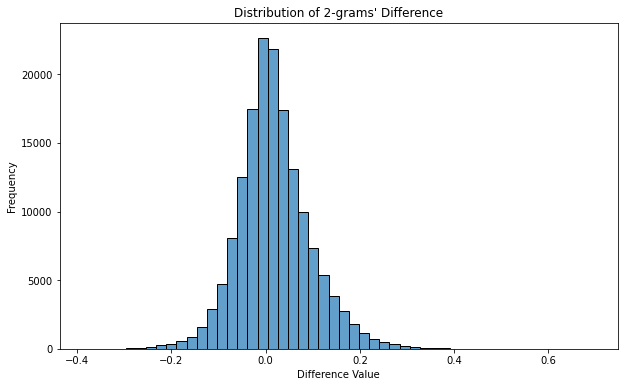

In [16]:
gram_diffs = []
test_df['id'] = test_df['ID'] - 25311
test_slope2 = test_df[test_df['id'].isin(list(long_labels_TF.keys()))]
test_slope2['pre_action'] = test_slope2['action'].shift(1)
test_slope2['2gram'] = test_slope2.apply(lambda row: (row['pre_action'], row['action']), axis=1)

for id_ in list(long_labels_TF.keys()):
    x = np.arange(1, len(long_prob_curve_TF1[id_]) + 1)
    fitted_curve = spline_curve[id_]
    
    diffs = fitted_curve[2:] - fitted_curve[:-2]
    gram_diffs.extend(diffs)
    diffs_with_nan = np.insert(diffs, 0, np.nan)
    diffs_with_nan = np.insert(diffs_with_nan, x[-1]-1, np.nan)
    test_slope2.loc[test_slope2['id'] == id_, 'gram_diffs'] = diffs_with_nan

plt.figure(figsize=(10, 6))
sns.histplot(gram_diffs, bins=50, alpha=0.7)
plt.title("Distribution of 2-grams' Difference")
plt.xlabel('Difference Value')
plt.ylabel('Frequency')
plt.show()

In [19]:
grouped1 = test_slope2.groupby('2gram')['gram_diffs'].median().reset_index()
grouped2 = test_slope2.groupby('2gram')['gram_diffs'].mean().reset_index(drop=True)
grouped3 = test_slope2.groupby('2gram')['gram_diffs'].count().reset_index(drop=True)
grouped = pd.concat([grouped1, grouped2, grouped3],axis=1)
grouped.columns = ['2gram', 'median', 'mean', 'count']

large_slope = grouped[(grouped['median'] > 0.08)&(grouped['count'] > 20)]
print(large_slope)

negtive_slope = grouped[(grouped['median'] > -0.05)&(grouped['median'] < -0.04)&(grouped['count'] > 20)]
print(negtive_slope)

            2gram    median      mean  count
72     (3.0, 4.0)  0.092553  0.091929   5114
87    (3.0, 19.0)  0.084195  0.082012    298
112   (4.0, 22.0)  0.137987  0.144422   4206
113   (4.0, 23.0)  0.090360  0.087593    134
141    (6.0, 3.0)  0.081515  0.075455   1829
371   (16.0, 3.0)  0.085103  0.077262    494
513   (22.0, 3.0)  0.097687  0.105335   1539
530  (22.0, 20.0)  0.081663  0.083550    745
          2gram    median      mean  count
23   (1.0, 1.0) -0.043343 -0.036474    185
27   (1.0, 5.0) -0.040562 -0.017555     51
47   (2.0, 1.0) -0.040635 -0.036661    106
121  (5.0, 7.0) -0.046311 -0.045099    666
169  (7.0, 7.0) -0.043917 -0.041708    263
187  (8.0, 1.0) -0.044332 -0.036416     38


### Task 3: Spline curves classification

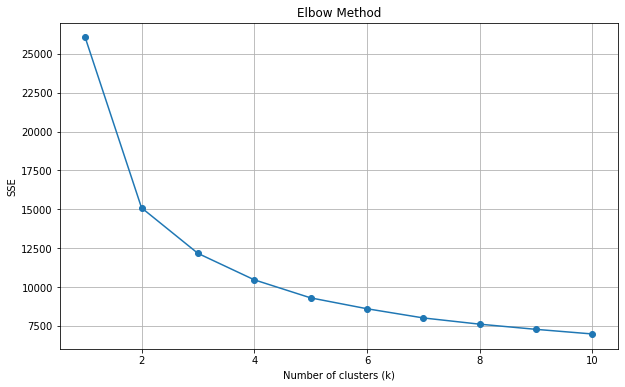

In [20]:
cluster_curves = []
for id_ in list(long_labels_TF.keys()):
    cluster_curves.append(all_spline[id_])
curves_array = np.array(cluster_curves)

sse = []

for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(curves_array)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

In [21]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(curves_array)
labels = kmeans.labels_

unique_clusters, counts = np.unique(labels, return_counts=True)
print("Cluster counts:")
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} samples")

cluster_groups = {}  
for idx, cluster_id in zip(long_labels_TF.keys(), labels):  
    if cluster_id not in cluster_groups:  
        cluster_groups[cluster_id] = []  
    cluster_groups[cluster_id].append(idx)  

Cluster counts:
Cluster 0: 1214 samples
Cluster 1: 1078 samples
Cluster 2: 1460 samples
Cluster 3: 982 samples


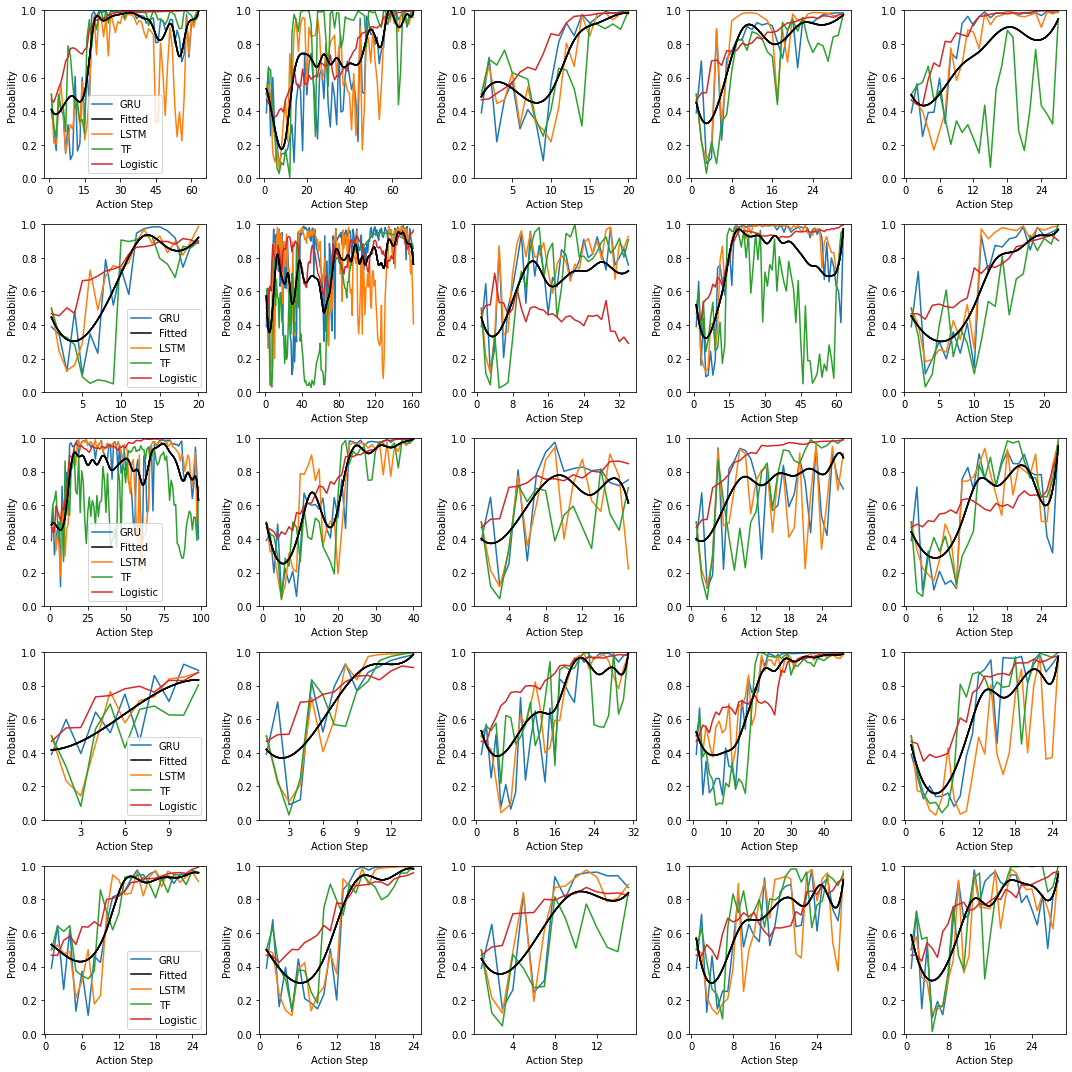

In [22]:
def plot_cluster_curves(cluster_id, cluster_indices, curve_dicts):  
    model_names = ['GRU', 'LSTM', 'TF', 'Logistic']
    valid_indices = cluster_indices[25:50] 
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    for i, idx in enumerate(valid_indices):  
        row, col = divmod(i, 5)  
        ax = axs[row, col]  
        fitted_label_added = False   

        for model_idx, curve_dict in enumerate(curve_dicts):  
            ax.plot(np.arange(1, len(curve_dict[idx]) + 1), curve_dict[idx], label=model_names[model_idx])
            x_fine = np.linspace(1, len(curve_dict[idx]), 200)  
            if not fitted_label_added:  
                ax.plot(x_fine, all_spline[idx], label='Fitted', color='black')  
                fitted_label_added = True
            else:  
                ax.plot(x_fine, all_spline[idx], color='black')          

        ax.set_ylim(0, 1)  
        ax.set_xlabel('Action Step')  
        ax.set_ylabel('Probability')  
        # ax.set_title(f'Cluster {cluster_id}, ID {idx}')  

        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))        
        if col == 0:
            ax.legend()  
  
plot_cluster_curves(0, cluster_groups[0], [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4])    
plt.tight_layout()  
plt.show()

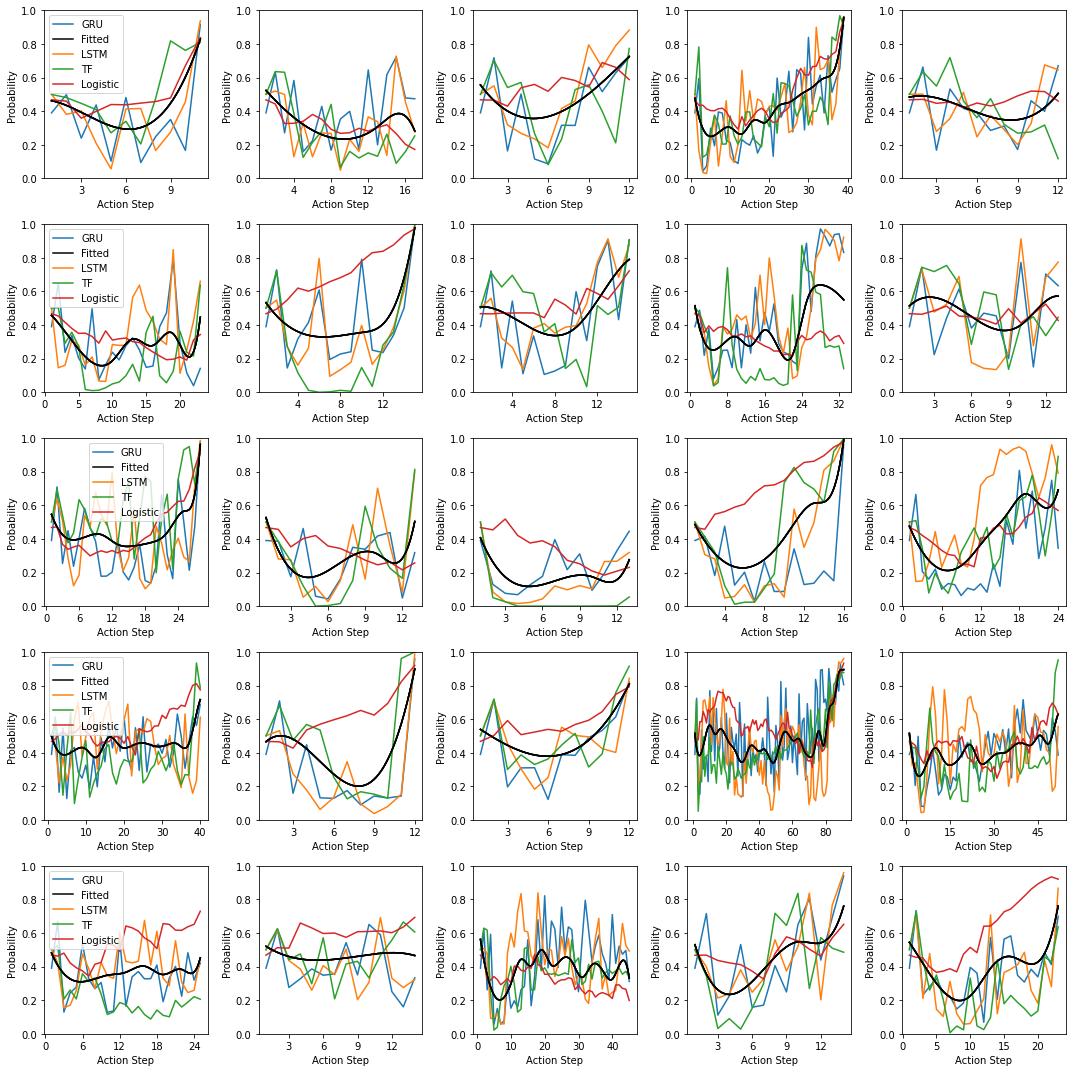

In [23]:
plot_cluster_curves(1, cluster_groups[1], [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4])    
plt.tight_layout()  
plt.show()

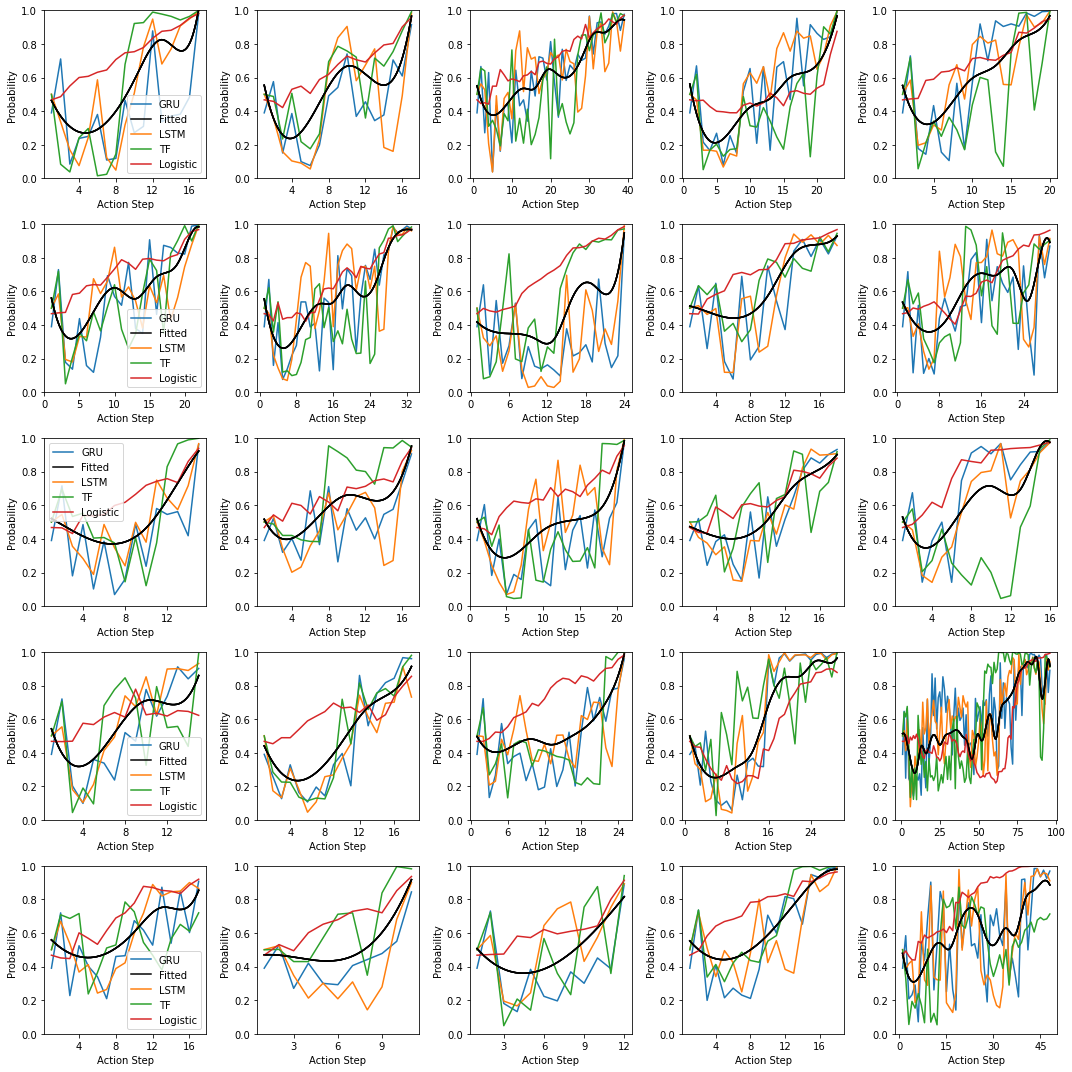

In [24]:
plot_cluster_curves(2, cluster_groups[2], [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4])    
plt.tight_layout()  
plt.show()

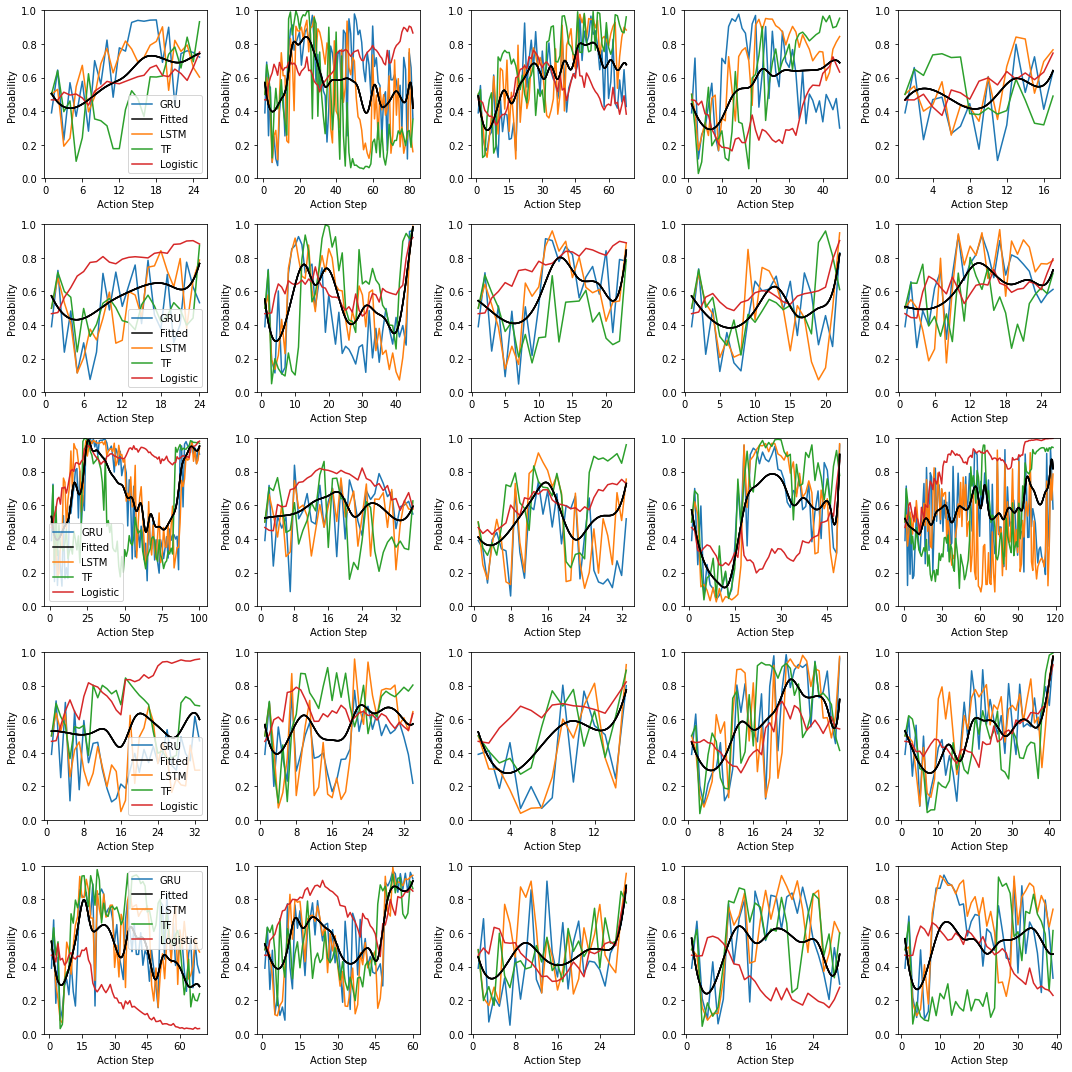

In [25]:
plot_cluster_curves(3, cluster_groups[3], [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4])    
plt.tight_layout()  
plt.show()